In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg19 import VGG19
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
#import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape
import keras.backend as K

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3485159156053729735, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16043448730
 locality {
   bus_id: 1
 }
 incarnation: 230164015447305404
 physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:00:05.0, compute capability: 6.1"]

In [3]:
with open('data-localize0.pckl','rb') as file:
    train_images,train_bboxes,train_labels,train_image_sizes,test_images,test_bboxes,test_labels,test_image_sizes = pickle.load(file)

In [4]:
#num_labels = len(np.unique(labels))

def iou_metric(y_true, y_pred):
    # iou as metric for bounding box regression
    # input must be as [x1, y1, x2, y2]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return iou    

In [6]:
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(
    weights='imagenet',
    include_top=True
)

In [5]:

for layer in cnn_base.layers:
    layer.trainable = False
    
x = cnn_base.get_layer('block5_pool').output
x = Conv2D(512, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(4, 4))(x)
x = BatchNormalization()(x)
x = Conv2D(4, kernel_size=(1, 1), padding="same")(x)
x = Reshape((4,),name='localization_output')(x)


y = cnn_base.get_layer('fc2').output
y = BatchNormalization()(y)
y = Dense(2048,activation='relu')(y)
y = BatchNormalization()(y)
y = Dense(test_labels.shape[1],activation='softmax',name='classification_output')(y)

losses = {
    "localization_output": "mean_squared_error",
    "classification_output": "categorical_crossentropy",
}
lossWeights = {"localization_output": 1.0, "classification_output": 1.0}

model = Model(inputs=cnn_base.input, outputs=[x,y])
model.compile(loss=losses, optimizer="adam", metrics={'classification_output':'accuracy', 'localization_output':['accuracy',iou_metric]})
model.save_weights('vgg19-localization-weights.hd5')

In [8]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, None, None, 3 96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_4[0][0]      
__________________________________________________________________________________________________
conv2d_4 (

In [12]:
train_pred = []
test_pred = []

train_scores = []
test_scores = []

for i in range(5):
    print("Loading file")
    with open('data-localize'+str(i)+'.pckl','rb') as file:
        train_images,train_bboxes,train_labels,train_image_sizes,test_images,test_bboxes,test_labels,test_image_sizes = pickle.load(file)
    try:
        model.load_weights('vgg19-localization'+str(i)+'.hd5')
    except:
        model.load_weights('vgg19-localization-weights.hd5')
    print("loaded")
    history = model.fit(x=np.array(train_images),y={"classification_output": np.array(train_labels), "localization_output": np.array(train_bboxes)},batch_size=20,epochs=30,
                       validation_data=(np.array(test_images),{"classification_output": test_labels, "localization_output": np.array(test_bboxes)}))
    train_score = model.evaluate(x=np.array(train_images),y={"classification_output": np.array(train_labels), "localization_output": np.array(train_bboxes)},batch_size=50)
    test_score = model.evaluate(x=np.array(test_images),y={"classification_output": test_labels, "localization_output": np.array(test_bboxes)},batch_size=50)
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print("predicting")
    print("Test Score",test_score)
    train_predictions = model.predict(x=np.array(train_images),batch_size=50)
    test_predictions = model.predict(x=np.array(test_images),batch_size=50)
    
    train_pred.append(train_predictions)
    test_pred.append(test_predictions)
    model.save_weights('vgg19-localization'+str(i)+'.hd5')

Loading file
loaded
Train on 7782 samples, validate on 649 samples
Epoch 1/30
7782/7782 [==============================] - 56s 7ms/step - loss: 7556.0168 - localization_output_loss: 7554.5526 - classification_output_loss: 1.4642 - localization_output_acc: 0.6394 - localization_output_iou_metric: 0.3044 - classification_output_acc: 0.6834 - val_loss: 952.3072 - val_localization_output_loss: 951.6054 - val_classification_output_loss: 0.7019 - val_localization_output_acc: 0.8028 - val_localization_output_iou_metric: 0.5318 - val_classification_output_acc: 0.7766
Epoch 2/30
7782/7782 [==============================] - 56s 7ms/step - loss: 833.2913 - localization_output_loss: 832.7536 - classification_output_loss: 0.5377 - localization_output_acc: 0.7717 - localization_output_iou_metric: 0.5677 - classification_output_acc: 0.8147 - val_loss: 845.9805 - val_localization_output_loss: 845.1513 - val_classification_output_loss: 0.8292 - val_localization_output_acc: 0.8166 - val_localization_out

Epoch 3/30
7782/7782 [==============================] - 55s 7ms/step - loss: 607.7282 - localization_output_loss: 607.3978 - classification_output_loss: 0.3304 - localization_output_acc: 0.8066 - localization_output_iou_metric: 0.6134 - classification_output_acc: 0.8797 - val_loss: 704.6789 - val_localization_output_loss: 703.8360 - val_classification_output_loss: 0.8429 - val_localization_output_acc: 0.7982 - val_localization_output_iou_metric: 0.5435 - val_classification_output_acc: 0.7612
Epoch 4/30
7782/7782 [==============================] - 56s 7ms/step - loss: 446.8869 - localization_output_loss: 446.6704 - classification_output_loss: 0.2165 - localization_output_acc: 0.8318 - localization_output_iou_metric: 0.6506 - classification_output_acc: 0.9219 - val_loss: 727.4003 - val_localization_output_loss: 726.5555 - val_classification_output_loss: 0.8449 - val_localization_output_acc: 0.7966 - val_localization_output_iou_metric: 0.5455 - val_classification_output_acc: 0.7488
Epoch 

Epoch 5/30
7782/7782 [==============================] - 55s 7ms/step - loss: 300.8208 - localization_output_loss: 300.6720 - classification_output_loss: 0.1488 - localization_output_acc: 0.8534 - localization_output_iou_metric: 0.6809 - classification_output_acc: 0.9519 - val_loss: 1210.9316 - val_localization_output_loss: 1210.0804 - val_classification_output_loss: 0.8512 - val_localization_output_acc: 0.7781 - val_localization_output_iou_metric: 0.5578 - val_classification_output_acc: 0.8012
Epoch 6/30
7782/7782 [==============================] - 56s 7ms/step - loss: 249.9187 - localization_output_loss: 249.7655 - classification_output_loss: 0.1532 - localization_output_acc: 0.8666 - localization_output_iou_metric: 0.7007 - classification_output_acc: 0.9485 - val_loss: 1202.2412 - val_localization_output_loss: 1201.2622 - val_classification_output_loss: 0.9791 - val_localization_output_acc: 0.7889 - val_localization_output_iou_metric: 0.5591 - val_classification_output_acc: 0.7689
Ep

Epoch 7/30
7785/7785 [==============================] - 56s 7ms/step - loss: 275.6015 - localization_output_loss: 275.4751 - classification_output_loss: 0.1264 - localization_output_acc: 0.8772 - localization_output_iou_metric: 0.7040 - classification_output_acc: 0.9517 - val_loss: 673.9258 - val_localization_output_loss: 672.6770 - val_classification_output_loss: 1.2488 - val_localization_output_acc: 0.7978 - val_localization_output_iou_metric: 0.5474 - val_classification_output_acc: 0.7577
Epoch 8/30
7785/7785 [==============================] - 55s 7ms/step - loss: 247.5223 - localization_output_loss: 247.4023 - classification_output_loss: 0.1200 - localization_output_acc: 0.8859 - localization_output_iou_metric: 0.7158 - classification_output_acc: 0.9580 - val_loss: 667.6919 - val_localization_output_loss: 666.5094 - val_classification_output_loss: 1.1825 - val_localization_output_acc: 0.7963 - val_localization_output_iou_metric: 0.5494 - val_classification_output_acc: 0.7747
Epoch 

Epoch 9/30
7785/7785 [==============================] - 56s 7ms/step - loss: 211.2331 - localization_output_loss: 211.1470 - classification_output_loss: 0.0861 - localization_output_acc: 0.8838 - localization_output_iou_metric: 0.7275 - classification_output_acc: 0.9717 - val_loss: 960.9321 - val_localization_output_loss: 959.7684 - val_classification_output_loss: 1.1637 - val_localization_output_acc: 0.7840 - val_localization_output_iou_metric: 0.5419 - val_classification_output_acc: 0.7963
Epoch 10/30
7785/7785 [==============================] - 56s 7ms/step - loss: 209.9342 - localization_output_loss: 209.8272 - classification_output_loss: 0.1069 - localization_output_acc: 0.8744 - localization_output_iou_metric: 0.7270 - classification_output_acc: 0.9631 - val_loss: 941.7776 - val_localization_output_loss: 940.7787 - val_classification_output_loss: 0.9989 - val_localization_output_acc: 0.7793 - val_localization_output_iou_metric: 0.5491 - val_classification_output_acc: 0.7994
Epoch

In [19]:
with open('vgg19-predictions.pckl','wb') as file:
    pickle.dump((train_pred,test_pred),file)

In [15]:
test_scores

[[878.8337838712201,
  877.1272337550558,
  1.70655428536684,
  0.7873651760017559,
  0.553764464767027,
  0.7673343555034584],
 [748.7408613725142,
  747.0825161456327,
  1.6583419371459445,
  0.771956855049486,
  0.5337489401614537,
  0.7657935295156412],
 [1213.0305305563247,
  1211.4661572754658,
  1.5643649152688142,
  0.7565485347401012,
  0.5615696980516055,
  0.7734976863640666],
 [682.3773376088084,
  680.7754951759621,
  1.6018430244775466,
  0.7993827191767869,
  0.5503914288164656,
  0.7777777790655325],
 [959.3765044035734,
  958.101055757499,
  1.2754541122251086,
  0.7669753016513071,
  0.544833728192765,
  0.8024691361703991]]

In [14]:
len(train_images)

7785

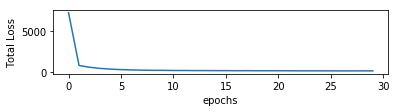

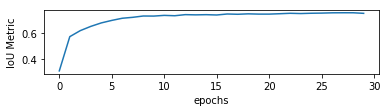

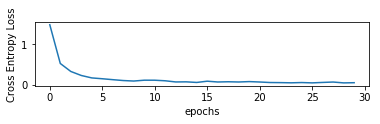

In [16]:
plt.subplot(3,1,1)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('Total Loss')
plt.show()
plt.subplot(3,1,2)
plt.plot(history.history['localization_output_iou_metric'])
plt.xlabel('epochs')
plt.ylabel('IoU Metric')
plt.show()
plt.subplot(3,1,3)
plt.plot(history.history['classification_output_loss'])
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [17]:
from sklearn import preprocessing
import numpy
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('classes.npy')

In [18]:
idx = np.random.randint(low=0,high=np.array(test_images).shape[0])
bb,classify = model.predict(np.expand_dims(np.array(test_images)[idx],0))
[[xmin,ymin,xmax,ymax]]= bb
img = cv2.rectangle(np.array(test_images)[idx], (xmin,ymin), (xmax,ymax), (0,255,0), 4)
pil_im = Image.fromarray(img)
a = np.argmax(classify,axis=1)[0]
label = le.inverse_transform(np.argmax(classify,axis=1))
#print(label[0])
#y = ymin - 15 if ymin - 15 > 15 else ymin + 15
plt.title("Predicted: "+label[0]+", Actual: "+le.inverse_transform(np.argmax(test_predictions[idx])))
plt.imshow(pil_im)
print(label[0])

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


IndexError: list index out of range

In [ ]:
# print(np.mean(np.array(test_cvscores)[:,1]))
# print(np.std(np.array(test_cvscores)[:,1]))

# print(np.mean(np.array(validation_cvscores)[:,1]))
# print(np.std(np.array(validation_cvscores)[:,1]))

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)!=predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)==predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predicted_labels,labels=np.unique(labels_))
print(cm)

In [ ]:
confusion_matrix(labels_test,predicted_labels)

labels_=list(np.unique(labels_test))
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_)
ax.set_yticklabels([''] + labels_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()